# Explore here

Sales forecasting system
We want to set up our company's warehouse in another location and we need to estimate the rate of sales, which has been increasing since the company's creation, for the next few months in order to provide the space we will need.

Step 1: Loading the dataset

Step 2: Construct and analyze the time serie
Construct the valid data structure for the time serie, graph it, and then analyze it and answer the following questions:

Which is the tensor of the time serie?
Which is the trend?
Is it stationary?
Is there variability or noise?

Step 3: Train an ARIMA
Use the training data to find the best parameterization of your ARIMA model.

Step 4: Predict with the test set
Now use the trained model with the test set and compare the points with the real ones. Measure the performance of the time serie.

Step 5: Save the model
Store the model in the corresponding folder.

In [1]:
import numpy as np
import statsmodels
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from pickle import dump
import pmdarima

In [2]:
raw_data = sns.load_dataset('flights')
raw_data

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121
...,...,...,...
139,1960,Aug,606
140,1960,Sep,508
141,1960,Oct,461
142,1960,Nov,390


In [3]:
# convert the three letter month abbreviation to a number
raw_data['month'] = pd.to_datetime(raw_data['month'], format='%b').dt.month
raw_data

,year,month,passengers
0,1949,1,112
1,1949,2,118
2,1949,3,132
3,1949,4,129
4,1949,5,121
...,...,...,...
139,1960,8,606
140,1960,9,508
141,1960,10,461
142,1960,11,390


In [4]:
raw_data['date'] = pd.to_datetime(raw_data[['year', 'month']].assign(day=1))
raw_data

,year,month,passengers,date
0,1949,1,112,1949-01-01
1,1949,2,118,1949-02-01
2,1949,3,132,1949-03-01
3,1949,4,129,1949-04-01
4,1949,5,121,1949-05-01
...,...,...,...,...
139,1960,8,606,1960-08-01
140,1960,9,508,1960-09-01
141,1960,10,461,1960-10-01
142,1960,11,390,1960-11-01


## Visulize the data

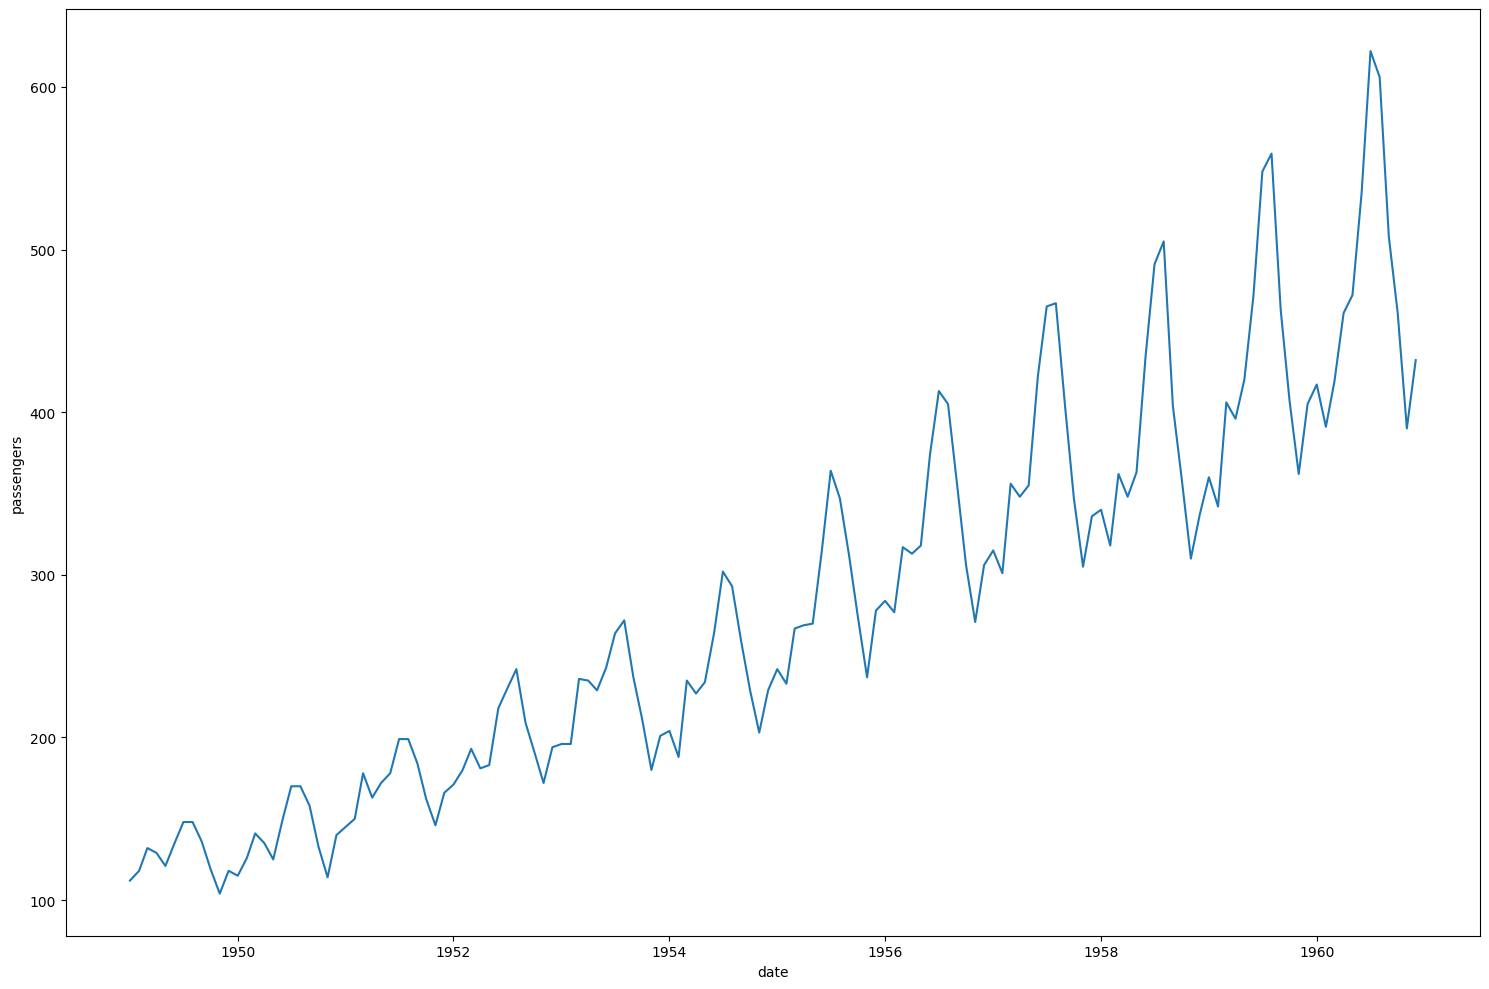

In [5]:
fig, axis = plt.subplots(figsize=(15, 10))

sns.lineplot(data=raw_data, x='date', y='passengers')

plt.tight_layout()

plt.show()

## Analysis of a time series

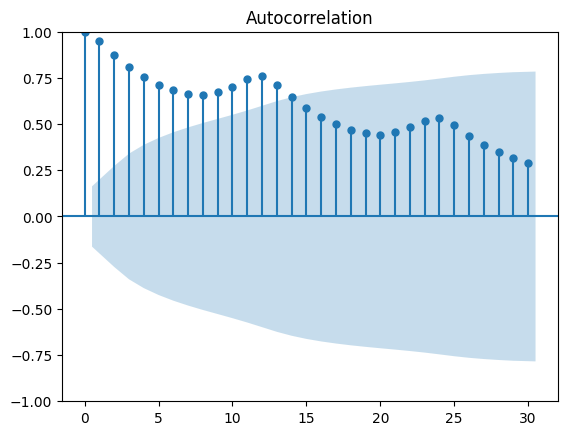

In [6]:
raw_data.set_index('date', inplace=True)
plot_acf(raw_data['passengers'], lags=30)  # Check correlations up to 30 days
plt.show()

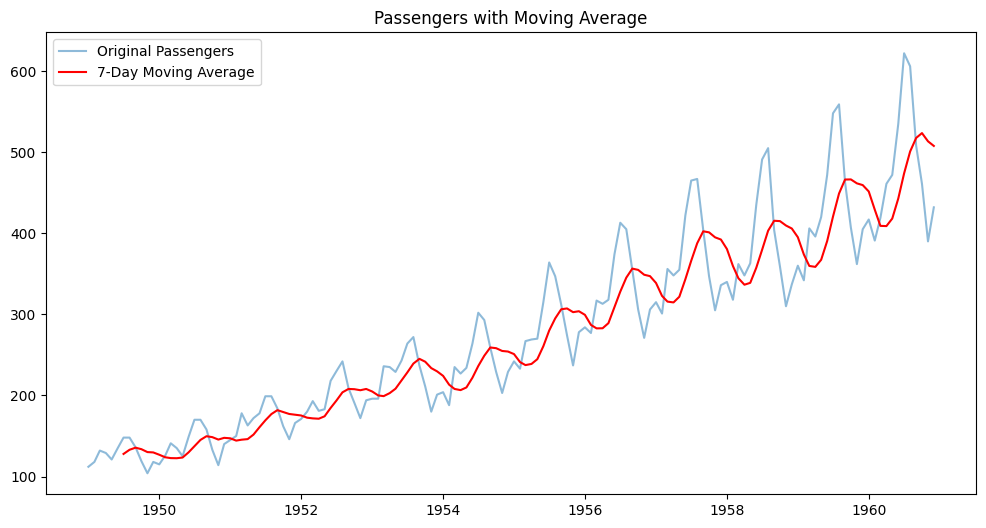

In [7]:
raw_data['passengers_ma'] = raw_data['passengers'].rolling(window=7).mean()  # 7-day moving average
plt.figure(figsize=(12,6))
plt.plot(raw_data.index, raw_data['passengers'], label='Original Passengers', alpha=0.5)
plt.plot(raw_data.index, raw_data['passengers_ma'], label='7-Day Moving Average', color='red')
plt.legend()
plt.title("Passengers with Moving Average")
plt.show()


In [8]:
decomposition = seasonal_decompose(raw_data['passengers'], model='additive', period=12)
decomposition

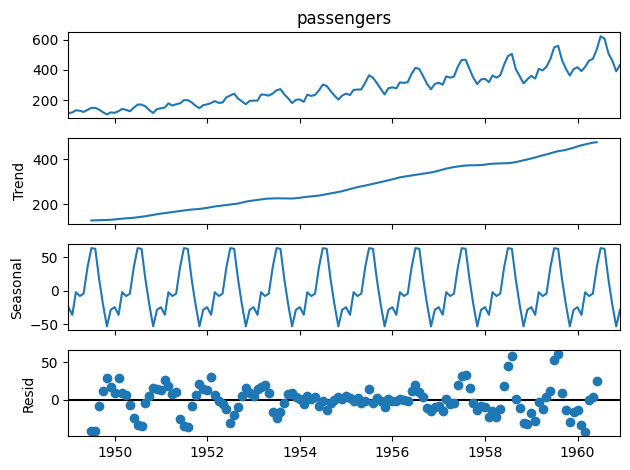

In [9]:
decomposition.plot()
plt.show()

In [10]:
decomposition = seasonal_decompose(raw_data['passengers'], model='additive', period=30)
decomposition

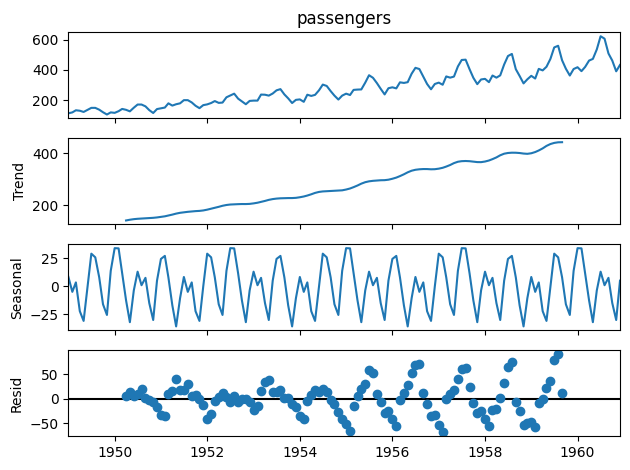

In [11]:
decomposition.plot()
plt.show()

In [12]:
# Decompose using both periods
decomp_7 = seasonal_decompose(raw_data['passengers'], model='additive', period=7)
decomp_30 = seasonal_decompose(raw_data['passengers'], model='additive', period=12)

# Compute the strength of seasonality
def seasonality_strength(decomposition):
    var_seasonal = np.var(decomposition.seasonal)  # Variance of seasonal component
    var_residual = np.var(decomposition.resid.dropna())  # Variance of residual component
    return var_seasonal / (var_seasonal + var_residual)  # Proportion explained by seasonality

strength_7 = seasonality_strength(decomp_7)
strength_30 = seasonality_strength(decomp_30)

print(f"Seasonality Strength (7-day): {strength_7:.4f}")
print(f"Seasonality Strength (30-day): {strength_30:.4f}")


Seasonality Strength (7-day): 0.0064
Seasonality Strength (30-day): 0.7787


A 30 day period has higher seasonality strength.

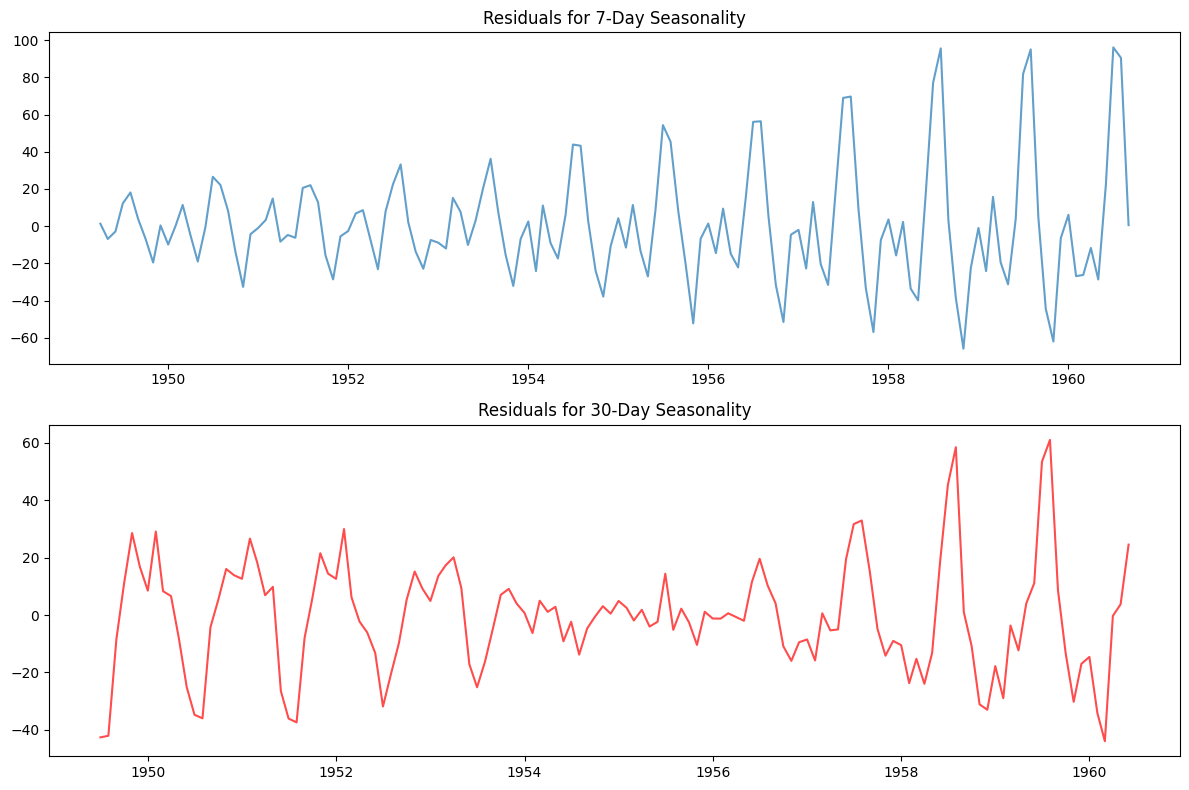

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(12,8))
axes[0].plot(decomp_7.resid, label='7-Day Residuals', alpha=0.7)
axes[0].set_title("Residuals for 7-Day Seasonality")
axes[1].plot(decomp_30.resid, label='30-Day Residuals', alpha=0.7, color='red')
axes[1].set_title("Residuals for 30-Day Seasonality")
plt.tight_layout()
plt.show()


A 7 day period has slightly lower residuals

## Test Stationarity

In [14]:
def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    if dftest[1] <= 0.05:
        print("Reject the null hypothesis, the time series is stationary")
    else:
        print("Fail to reject the null hypothesis, the time series is non-stationary")
    
    return dfoutput

test_stationarity(raw_data['passengers'])

Dickey-Fuller test results:
Fail to reject the null hypothesis, the time series is non-stationary


Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

Note that the arima model automatically makes the data stationary so I do not have to do that preprocessing step.

# Train and test the ARIMA Model

In [15]:
# perform differencing to convert the data into stationary data then drop any resulting na values
stationary_data = raw_data['passengers'].diff().dropna()
test_stationarity(stationary_data)

Dickey-Fuller test results:
Fail to reject the null hypothesis, the time series is non-stationary


Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

In [16]:
import warnings
warnings.filterwarnings('ignore')
arima_model = pmdarima.auto_arima(raw_data['passengers'], seasonal = True, stationary=False, trace=True, m = 12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1020.048, Time=0.87 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.12 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=1019.935, Time=0.51 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=1019.290, Time=0.15 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=1019.546, Time=0.45 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1024.160, Time=0.08 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1017.847, Time=0.15 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=1017.914, Time=0.51 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1018.359, Time=0.47 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=1018.248, Time=0.90 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.05 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=1022.393, Time=0.05 sec
 ARIMA(3,1,1)(0,1,0

 ARIMA(2,1,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.47 sec

Best model:  ARIMA(2,1,1)(0,1,0)[12]          
Total fit time: 5.450 seconds


In [17]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                -504.923
Date:                             Thu, 27 Mar 2025   AIC                           1017.847
Time:                                     00:02:36   BIC                           1029.348
Sample:                                 01-01-1949   HQIC                          1022.520
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5960      0.085      6.987      0.000       0.429       0.763
ar.L2          0.2143      0.091      2.343      0.019       0.035       0.394
ma.L1         -0.9819      0.038    -25.602      0.000      -1.057      -0.907
sigma2       129.3133     14.556      8.884      0.000     100.783     157.843
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.68
Prob(Q):                              0.98   Prob(JB):                         0.02
Heteroskedasticity (H):               2.33   Skew:                            -0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
forecast = arima_model.predict(10)
forecast

1961-01-01    445.634924
1961-02-01    420.395010
1961-03-01    449.198328
1961-04-01    491.839952
1961-05-01    503.394475
1961-06-01    566.862441
1961-07-01    654.260157
1961-08-01    638.597459
1961-09-01    540.883703
1961-10-01    494.126573
Freq: MS, dtype: float64

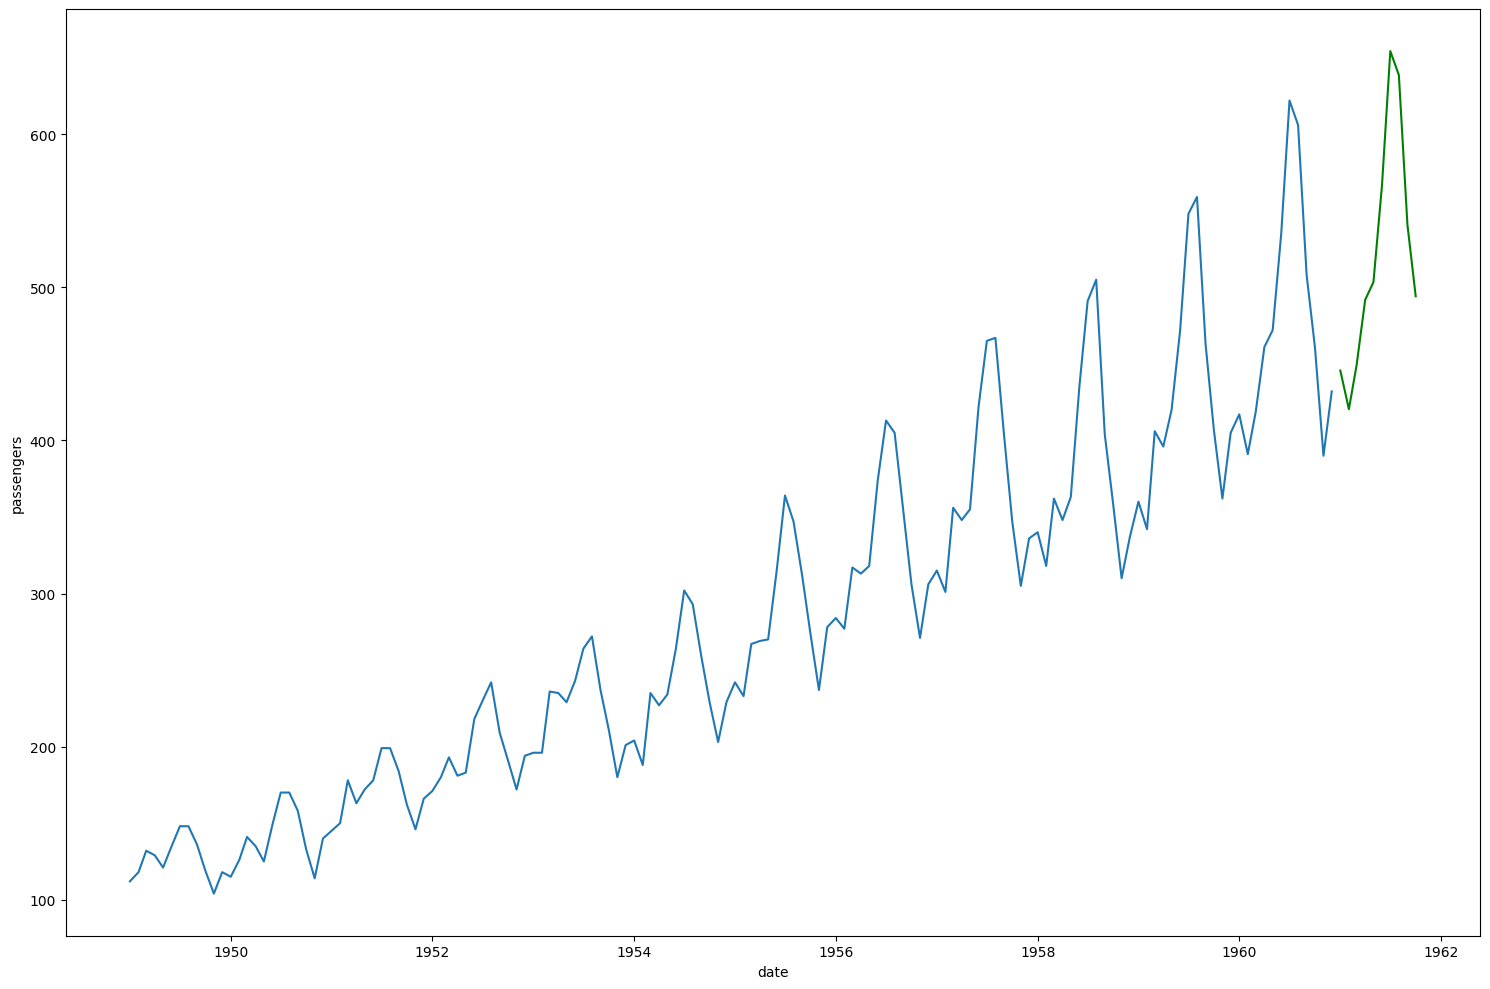

In [19]:
fig, axis = plt.subplots(figsize=(15, 10))

sns.lineplot(data=raw_data['passengers'])
sns.lineplot(data=forecast, c='green')

plt.tight_layout()

plt.show()

In [20]:
#dump(arima_model, open("../models/arima_seasonal-False_trace-True_m-30.sav", "wb"))